In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import logging
import penaltyblog as pb
from types import SimpleNamespace
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
import sys
sys.path.append('../src')
from dixon_coles import create_team_ratings, simulate_league, process_simulation_results

In [3]:
# Set up basic logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# Functions

In [4]:
def initialize_webdriver(url):

    # initialize webdriver
    driver = webdriver.Chrome()
    # load the website
    driver.get(url)

    return driver

In [5]:
def scroll_page(driver):

    # Scroll down repeatedly (to load more content)
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)  # Wait for loading

        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break  # No more content to load
        last_height = new_height

In [6]:
def get_results(driver):

    # Get teams
    elements = driver.find_elements(By.CLASS_NAME, 'teamname')
    teams = [elem.text for elem in elements]

    # Get goals
    elements = driver.find_elements(By.CLASS_NAME, 'scorefs')
    goals = [elem.text for elem in elements]

    # Check if the number of teams and goals match and only use games where the result is known
    teams = teams[-len(goals):]

    # create dataframe
    df = pd.DataFrame(columns=['team_home', 'team_away', 'goals_home', 'goals_away'])
    df.team_home = teams[0::2]
    df.team_away = teams[1::2]
    df.goals_home = goals[0::2]
    df.goals_away = goals[1::2]

    return df

In [7]:
def get_fixtures(driver):
    
    # get teams
    elements = driver.find_elements(By.CLASS_NAME, 'teamname')
    teams = [elem.text for elem in elements]

    # re-create fixtures
    fixtures = pd.DataFrame(columns=['Home', 'Away'])
    fixtures.Home = teams[0::2]
    fixtures.Away = teams[1::2]
    
    return fixtures

In [8]:
def get_table(driver):

    # get teams
    elements = driver.find_elements(By.CLASS_NAME, 'text-start')
    teams = [elem.text for elem in elements]
    teams = teams[7::5]

    # get stats
    elements = driver.find_elements(By.CLASS_NAME, 'text-center')
    stats = [elem.text for elem in elements]
    stats = stats[6::]

    table = pd.DataFrame(columns=['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts'])
    table.Rk = np.arange(1, len(teams)+1)
    table.Squad = teams
    table.MP = stats[0::6]
    table.W = stats[1::6]
    table.D = stats[2::6]
    table.L = stats[3::6]
    table.GF = [x.split('–')[0] for x in stats[4::6]]
    table.GA = [x.split('–')[1] for x in stats[4::6]]
    table.GD = table['GF'].astype(int) - table['GA'].astype(int)
    table.Pts = stats[5::6]

    # convert to numeric
    table[['Rk', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']] = (
        table[['Rk', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']].apply(pd.to_numeric, errors='coerce')
    )

    return table

# Scrape data

In [9]:
#my_group = 3
#driver = initialize_webdriver(f'https://tulospalvelu.palloliitto.fi/category/M7!etejp25/group/{my_group}/results')
driver = initialize_webdriver(f'https://tulospalvelu.palloliitto.fi/category/M7!etejp25/results') # all results
scroll_page(driver)

In [10]:
df = get_results(driver)
#df.to_csv(f'../data/results_kevat25.csv', index=False)
df

,team_home,team_away,goals_home,goals_away
0,Kullervo/Überkleber,JJ Vepo,3,0
1,Trikiinit,Kullervo,4,1
2,PK-35/Äijät,Cosmos,2,1
3,FC Pakila,MoPo,5,1
4,Kilo IF/2,OT-77,3,2
...,...,...,...,...
125,FC Lähiö,Valtti/TDJ,1,1
126,JJ Vepo,LPS/7,1,2
127,Ponnistus/TK,Tavastia/FC Mojo,2,6
128,Valtti/4,KOPSE/CRPS FC,3,0


In [11]:
my_group = 4
driver = initialize_webdriver(f'https://tulospalvelu.palloliitto.fi/category/M7!etejp25/group/{my_group}/fixtures')
scroll_page(driver)

In [12]:
fixtures = get_fixtures(driver)
#fixtures.to_csv(f'../data/fixtures_kevat25.csv', index=False)
fixtures

,Home,Away
0,Käpylän Sekunda,PK-35/Äijät
1,Cosmos,Valtti/4
2,MLHF/Reserves,Trikiinit
3,Kullervo,Valtti/TDJ
4,Cosmos,Käpylän Sekunda
5,MLHF/Reserves,Valtti/TDJ
6,PK-35/Äijät,FC Lähiö
7,Valtti/4,Trikiinit
8,Trikiinit,PK-35/Äijät
9,Kullervo,MLHF/Reserves


In [13]:
driver = initialize_webdriver(f'https://tulospalvelu.palloliitto.fi/category/M7!etejp25/group/{my_group}/')

In [14]:
table = get_table(driver)
#table.to_csv(f'../data/table_syksy1_25.csv', index=False)
table

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts
0,1,Valtti/TDJ,1,1,0,0,5,0,5,3
1,2,Trikiinit,1,1,0,0,4,1,3,3
2,3,PK-35/Äijät,1,1,0,0,2,1,1,3
3,4,FC Lähiö,1,1,0,0,2,1,1,3
4,5,Cosmos,1,0,0,1,1,2,-1,0
5,6,MLHF/Reserves,1,0,0,1,1,2,-1,0
6,7,Kullervo,1,0,0,1,1,4,-3,0
7,8,Käpylän Sekunda,1,0,0,1,0,5,-5,0
8,9,Valtti/4,0,0,0,0,0,0,0,0


# Model

In [15]:
clf = pb.models.DixonColesGoalModel(
    df["goals_home"], df["goals_away"], df["team_home"], df["team_away"],
)

clf.fit()

In [16]:
clf.get_params()

{'attack_AC StaSi/Europort': np.float64(1.11857491809398),
 'attack_AFC EMU': np.float64(1.2010479534613931),
 'attack_Cosmos': np.float64(0.9723693489895427),
 'attack_FC Lähiö': np.float64(1.7431603253578927),
 'attack_FC POHU/Kova Kamppi': np.float64(1.5244651289601279),
 'attack_FC POHU/Sober': np.float64(0.47920992371981935),
 'attack_FC Pakila': np.float64(0.859072941514227),
 'attack_FC Puimur': np.float64(0.4574153685815606),
 'attack_HPS/Rangers': np.float64(1.6175283976044876),
 'attack_HeKuLa': np.float64(0.18566228360194162),
 'attack_JJ Vepo': np.float64(0.6144218351439167),
 'attack_KOPSE/CRPS FC': np.float64(0.9308300777132376),
 'attack_Kasiysi/3': np.float64(-0.031034366149256244),
 'attack_Kilo IF/2': np.float64(0.6269916268782275),
 'attack_Kullervo': np.float64(0.916092654580319),
 'attack_Kullervo/Überkleber': np.float64(1.34319384374409),
 'attack_Käpylän Sekunda': np.float64(1.4627451216829823),
 'attack_LPS/7': np.float64(0.7157305473660058),
 'attack_MLHF/Reser

# Ratings

In [17]:
teams = df['team_home'].unique()
args = SimpleNamespace(save_simulation_results=True, league=f'Syksy')
ratings_df = create_team_ratings(clf, teams, args, export_ratings=True)

2025-08-11 17:58:32,041 - INFO - Creating team ratings...
2025-08-11 17:58:32,042 - INFO - Median attack value: 1.11857491809398, Team(s): ['AC StaSi/Europort']
2025-08-11 17:58:32,042 - INFO - Median defense value: -0.40589062197182973, Team(s): ['Kullervo/Überkleber']
2025-08-11 17:58:32,051 - INFO - Team ratings:
                   team  attack_rating  defense_rating  goal_difference_rating
1            Valtti/TDJ       4.119677        0.771478                3.348200
2              FC Lähiö       3.808631        0.903342                2.905289
3           HPS/Rangers       3.358981        1.285925                2.073056
4      Tavastia/FC Mojo       3.658569        1.654438                2.004130
5         MLHF/Reserves       2.837489        1.109124                1.728364
6   FC POHU/Kova Kamppi       3.060488        1.373448                1.687040
7          Ponnistus/TK       2.872746        1.431172                1.441574
8           PK-35/Äijät       2.783727        1.44

# Simulation

In [18]:
nr_simulations = 1000
simulation_results_df = simulate_league(clf, table, fixtures, nr_simulations)

2025-08-11 17:59:44,228 - INFO - Starting to run simulations...
Simulating...: 100%|██████████| 1000/1000 [01:18<00:00, 12.79it/s]
2025-08-11 18:01:02,436 - INFO - Simulations finished.


2025-08-11 18:01:07,595 - INFO - Processing simulation results...


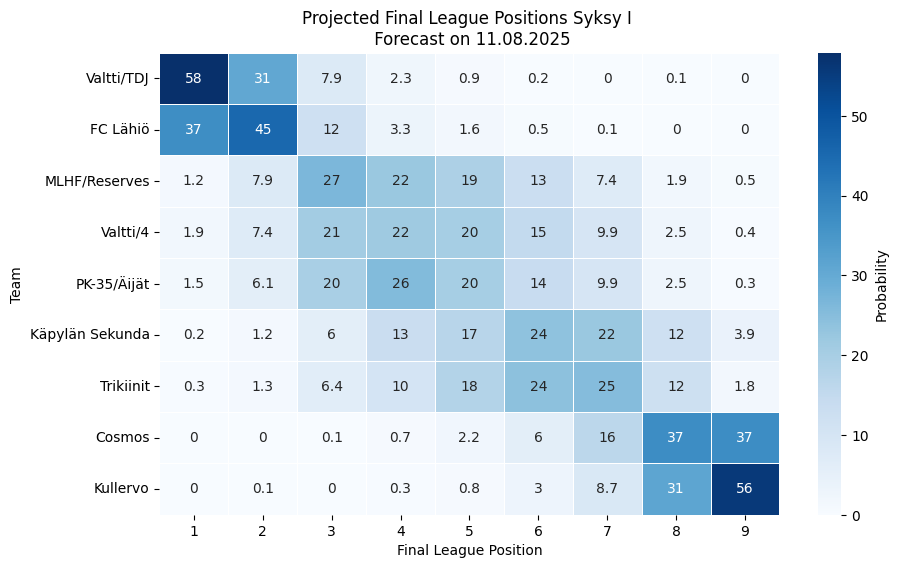

In [19]:
args = SimpleNamespace(save_simulation_results=True, league='Syksy I')
process_simulation_results(simulation_results_df, nr_simulations, args)

# Kevät analysis

This does not seem to work...

### Group 1

In [ ]:
clf_1 = pb.models.DixonColesGoalModel(
    df["goals_home"], df["goals_away"], df["team_home"], df["team_away"],
)

clf_1.fit()

display(clf_1.get_params())

In [ ]:
clf.get_params()

In [ ]:
import plotly.graph_objects as go   

In [ ]:
teams = df.team_home.unique()

In [ ]:
string = 'attack_Cosmos'
string[7:]

In [ ]:
# Extract values
attack_values = [value for key, value in clf_1.get_params().items() if key.startswith('attack')]
defence_values = [value for key, value in clf_1.get_params().items() if key.startswith('defence')]

# Create a combined figure manually
fig = go.Figure()

# Add attack histogram
fig.add_trace(go.Histogram(
    x=attack_values,
    name='Attack',
    opacity=0.6,
    marker_color='blue'
))

# Add defence histogram
fig.add_trace(go.Histogram(
    x=defence_values,
    name='Defence',
    opacity=0.6,
    marker_color='red'
))

# Update layout
fig.update_layout(
    barmode='overlay',  # or 'group' if you want them side by side
    title='Attack vs Defence Parameter Distributions',
    xaxis_title='Value',
    yaxis_title='Count',
    legend_title='Parameter Type'
)

fig.show()


In [ ]:
# Extract values
attack_values = [value for key, value in clf.get_params().items() if ((key[7:] in teams) & (key.startswith('attack_')))]
defence_values = [value for key, value in clf.get_params().items() if ((key[8:] in teams) & (key.startswith('defence_')))]

# Create a combined figure manually
fig = go.Figure()

# Add attack histogram
fig.add_trace(go.Histogram(
    x=attack_values,
    name='Attack',
    opacity=0.6,
    marker_color='blue'
))

# Add defence histogram
fig.add_trace(go.Histogram(
    x=defence_values,
    name='Defence',
    opacity=0.6,
    marker_color='red'
))

# Update layout
fig.update_layout(
    barmode='overlay',  # or 'group' if you want them side by side
    title='Attack vs Defence Parameter Distributions',
    xaxis_title='Value',
    yaxis_title='Count',
    legend_title='Parameter Type'
)

fig.show()


In [ ]:
attack_values = [value for key, value in clf.get_params().items() if ((key[7:] in teams) & (key.startswith('attack_')))]
defence_values = [value for key, value in clf.get_params().items() if ((key[8:] in teams) & (key.startswith('defence_')))]

attack_values_1 = [value for key, value in clf_1.get_params().items() if key.startswith('attack')]
defence_values_1 = [value for key, value in clf_1.get_params().items() if key.startswith('defence')]

team_keys = [key[7:] for key, value in clf.get_params().items() if ((key[7:] in teams) & (key.startswith('attack_')))]
team_keys_1 = [key[7:] for key, value in clf_1.get_params().items() if ((key.startswith('attack_')))]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=attack_values,
    y=defence_values,
    opacity=0.6,
    marker_color='blue',
    mode='markers',
    hovertext=team_keys,
    name='clf'
))

fig.add_trace(go.Scatter(
    x=attack_values_1,
    y=defence_values_1,
    opacity=0.6,
    marker_color='red',
    mode='markers',
    hovertext=team_keys_1,
    name='clf_1'
))

In [ ]:
display(clf.get_params()['rho'])
display(clf_1.get_params()['rho'])

In [ ]:
display(clf.get_params()['home_advantage'])
display(clf_1.get_params()['home_advantage'])

In [ ]:
display(np.mean(attack_values))
display(np.mean(attack_values_1))

In [ ]:
attack_values_clf = [value for key, value in clf.get_params().items() if ((key.startswith('attack_')))]
display(np.mean(attack_values_clf))

### Group 2

In [ ]:
clf_2 = pb.models.DixonColesGoalModel(
    df["goals_home"], df["goals_away"], df["team_home"], df["team_away"],
)

clf_2.fit()

display(clf_2.get_params())

### Group 3

In [ ]:
clf_3 = pb.models.DixonColesGoalModel(
    df["goals_home"], df["goals_away"], df["team_home"], df["team_away"],
)

clf_3.fit()

display(clf_3.get_params())

### Group comparison

In [ ]:
attack_values_list = []
defence_values_list = []
for my_clf in [clf_1, clf_2, clf_3]:
    attack_values_list.append([value for key, value in my_clf.get_params().items() if key.startswith('attack')])
    defence_values_list.append([value for key, value in my_clf.get_params().items() if key.startswith('defence')])

In [ ]:
print('Individual group models')
for i in range(3):
    group_mean_attack = np.mean(attack_values_list[i])
    group_mean_defence = np.mean(defence_values_list[i])
    print(f'Group {i+1} mean attack: {group_mean_attack}, mean defence: {group_mean_defence}')

In [ ]:
team_list = []
for my_clf in [clf_1, clf_2, clf_3]:
    team_list.append([key[7:] for key, value in my_clf.get_params().items() if key.startswith('attack')])

In [ ]:
attack_values_list = []
defence_values_list = []
for i in range(3):
    attack_values_list.append([value for key, value in clf.get_params().items() if ((key.startswith('attack')) & (key[7:] in team_list[i]))])
    defence_values_list.append([value for key, value in clf.get_params().items() if ((key.startswith('defence')) & (key[8:] in team_list[i]))])

In [ ]:
print('Total model')
for i in range(3):
    group_mean_attack = np.mean(attack_values_list[i])
    group_mean_defence = np.mean(defence_values_list[i])
    print(f'Group {i+1} mean attack: {group_mean_attack}, mean defence: {group_mean_defence}')

In [ ]:
clf_1.predict('Trikiinit', 'Kullervo')

In [ ]:
clf.predict('Trikiinit', 'Kullervo')

In [ ]:
clf_2.predict('Valtti/TDJ', 'FC Lähiö')

In [ ]:
clf.predict('Valtti/TDJ', 'FC Lähiö')

In [ ]:
clf_3.predict('Valtti/4', 'LPS/7')

In [ ]:
clf.predict('Valtti/4', 'LPS/7')

## Combined model

In [ ]:
display(clf.get_params())

In [ ]:
keys_to_exclude = {'home_advantage', 'rho'}
aux_dict = {
    **{k: v for k, v in clf_1.get_params().items() if k not in keys_to_exclude},
    **{k: v for k, v in clf_2.get_params().items() if k not in keys_to_exclude},
    **{k: v for k, v in clf_3.get_params().items() if k not in keys_to_exclude},
}

# Sort the dictionary by keys
aux_dict_sorted = {key: aux_dict[key] for key in sorted(aux_dict)}

aux_dict_sorted

In [ ]:
np.array(list(aux_dict_sorted.values()))

In [ ]:
clf._params[:-2] = np.array(list(aux_dict_sorted.values()))

In [ ]:
clf.get_params()

In [ ]:
clf.__dict__['teams_home']

In [ ]:
teams = fixtures.Home.unique()
args = SimpleNamespace(save_simulation_results=False, league=f'Kevät')
ratings_df = create_team_ratings(clf, teams, args, export_ratings=False)

# Misc

In [ ]:
all_ratings = []

In [ ]:
all_ratings.append(ratings_df)

In [ ]:
all_ratings_df = pd.concat(all_ratings).sort_values(by='goal_difference_rating', ascending=False).reset_index(drop=True)
all_ratings_df

In [ ]:
all_ratings_df.to_csv('../output/ratings_Kevät.csv', index=False)

In [ ]:
import dataframe_image as dfi
dfi.export(all_ratings_df, f"../output/ratings_Kevät.png", table_conversion='matplotlib',)

# Development

## results

In [ ]:
# Initialize the Chrome driver
driver = webdriver.Chrome()

# Load the website
driver.get('https://tulospalvelu.palloliitto.fi/category/M7!etejp25/group/1/results')

In [ ]:
elements = driver.find_elements(By.CLASS_NAME, 'teamname')
teams = [elem.text for elem in elements]
print(teams)

In [ ]:
elements = driver.find_elements(By.CLASS_NAME, 'scorefs')
goals = [elem.text for elem in elements]
print(goals)

In [ ]:
elements = driver.find_elements(By.CLASS_NAME, 'match_status')
status = [elem.text for elem in elements]
print(status)

In [ ]:
df = pd.DataFrame(columns=['team_home', 'team_away', 'goals_home', 'goals_away'])
df

In [ ]:
df.team_home = teams[0::2]
df.team_away = teams[1::2]
df.goals_home = goals[0::2]
df.goals_away = goals[1::2]
df

## fixtures

In [ ]:
# Initialize the Chrome driver
driver = webdriver.Chrome()

# Load the website
driver.get('https://tulospalvelu.palloliitto.fi/category/M7!etejp25/group/1/fixtures')

In [ ]:
elements = driver.find_elements(By.CLASS_NAME, 'teamname')
teams = [elem.text for elem in elements]
print(teams)

In [ ]:
fixtures = pd.DataFrame(columns=['Home', 'Away'])
fixtures.Home = teams[0::2]
fixtures.Away = teams[1::2]
fixtures

## table

In [ ]:
# Initialize the Chrome driver
driver = webdriver.Chrome()

# Load the website
driver.get('https://tulospalvelu.palloliitto.fi/category/M7!etejp25/group/1/')

In [ ]:
elements = driver.find_elements(By.CLASS_NAME, 'text-start')
teams = [elem.text for elem in elements]
teams = teams[7::5]
print(teams)

In [ ]:
elements = driver.find_elements(By.CLASS_NAME, 'text-center')
stats = [elem.text for elem in elements]
stats = stats[6::]
print(stats)

In [ ]:
table = pd.DataFrame(columns=['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts'])
table

In [ ]:
stats[4::6][0].split('–')[0]

In [ ]:
[x.split('–')[0] for x in stats[4::6]]

In [ ]:
table.Rk = np.arange(1, len(teams)+1)
table.Squad = teams
table.MP = stats[0::6]
table.W = stats[1::6]
table.D = stats[2::6]
table.L = stats[3::6]
table.GF = [x.split('–')[0] for x in stats[4::6]]
table.GA = [x.split('–')[1] for x in stats[4::6]]
table.GD = table['GF'].astype(int) - table['GA'].astype(int)
table.Pts = stats[5::6]
table

## lineups

### Get match ids

In [ ]:
# Initialize the Chrome driver
driver = webdriver.Chrome()

# Load the website
driver.get('https://tulospalvelu.palloliitto.fi/category/M7!etejp25/results')

In [ ]:
# Scroll down repeatedly (to load more content)

last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  # Wait for loading

    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break  # No more content to load
    last_height = new_height

In [ ]:
# Find all elements with a 'matchid' attribute
elements = driver.find_elements(By.XPATH, '//*[@matchid]')
# Extract all match IDs
match_ids = [el.get_attribute("matchid") for el in elements]
print(len(np.unique(match_ids)))

### Get lineups

In [ ]:
# Initialize the Chrome driver
driver = webdriver.Chrome()
wait = WebDriverWait(driver, 10)  # wait up to 10 seconds

all_game_data = []
for match_id in np.unique(match_ids):
    # Load the website
    driver.get(f'https://tulospalvelu.palloliitto.fi/match/{match_id}/lineups')
    wait.until(EC.presence_of_element_located((By.ID, "matchscore")))
    
    # Extract team names
    home_team = driver.find_element(By.CSS_SELECTOR, "#A_team .teamname").text.strip()
    away_team = driver.find_element(By.CSS_SELECTOR, "#B_team .teamname").text.strip()

    # Extract match score (e.g., "2 – 1")
    score = driver.find_element(By.ID, "matchscore").text.strip().split("\n")[0]  # Remove subscore like (0–0)

    home_team_goals = int(score.split('–')[0])
    away_team_goals = int(score.split('–')[1])

    # Print result
    print(f"{home_team} vs {away_team}: {home_team_goals} – {away_team_goals}")

    # Find both player tables
    player_tables = driver.find_elements(By.XPATH, '//div[contains(@class, "playerlist")]')
    
    all_players = []
    teams = [home_team, away_team]
    goals = [home_team_goals, away_team_goals]
    # Iterate through each player table (0 = first team, 1 = second team)
    for idx, table in enumerate(player_tables):
        team_label = teams[idx]
        
        # Find all player rows in this table
        rows = table.find_elements(By.XPATH, './/table//tr')
        
        for row in rows:
            try:
                # Extract shirt number
                shirt_number = row.find_element(By.XPATH, './/span[contains(@class, "shirtnumber")]').text.strip()
            except:
                shirt_number = ""

            try:
                # Extract name (text from the namenarrow span)
                name_elem = row.find_element(By.XPATH, './/span[contains(@class, "undefined")]')
                name_text = name_elem.text.strip()

                # Remove "| MV", "| C", etc. if present
                player_name = name_text.split('|')[0].strip()
            except:
                player_name = "Unknown"

            all_players.append({
                "team": team_label,
                "shirt_number": shirt_number,
                "name": player_name,
                "goals_scored": goals[idx],
                "goals_conceded": goals[1 - idx]  # Goals conceded is the other team's score
            })

    # Print all players
    for player in all_players:
        print(f"{player['team']} - {player['shirt_number']} {player['name']}: Team goals scored: {player['goals_scored']}, Goals conceded: {player['goals_conceded']}")

    # Append to all game data
    all_game_data.append({
        "match_id": match_id,
        "home_team": home_team,
        "away_team": away_team,
        "home_goals": home_team_goals,
        "away_goals": away_team_goals,
        "players": all_players
    })

# Close the driver after scraping
driver.quit()

In [ ]:
len(all_game_data)

In [ ]:
df = pd.DataFrame(all_game_data)
df

In [ ]:
df_exploded = df.explode('players').reset_index(drop=True)
df_exploded

In [ ]:
# Normalize the dictionary into columns
df_normalized = pd.concat(
    [df_exploded.drop(columns=['players']),
     pd.json_normalize(df_exploded['players'])],
    axis=1
)
df_normalized

In [ ]:
df_normalized.to_csv('../data/player_data_kevat.csv', index=False)